In [35]:
import pandas as pd

df = pd.read_csv('sp500_index.csv')
df['Close'] = df['S&P500']
df = df[['Date', 'Close']]

In [36]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)


In [37]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

0      2012-10-22
1      2012-10-23
2      2012-10-24
3      2012-10-25
4      2012-10-26
          ...    
2512   2022-10-17
2513   2022-10-18
2514   2022-10-19
2515   2022-10-20
2516   2022-10-21
Name: Date, Length: 2517, dtype: datetime64[ns]

In [38]:
df.index = df.pop('Date')
df.head()

,Close
Date,
2012-10-22,1433.82
2012-10-23,1413.11
2012-10-24,1408.75
2012-10-25,1412.97
2012-10-26,1411.94


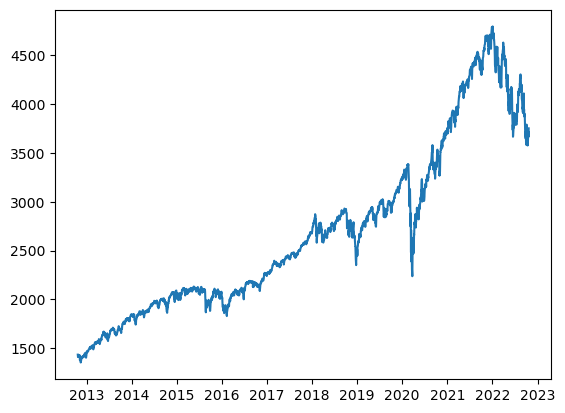

In [39]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [40]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-03-25', 
                                '2022-03-23', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,3940.59,3910.52,3889.14,3909.52
1,2021-03-26,3910.52,3889.14,3909.52,3974.54
2,2021-03-29,3889.14,3909.52,3974.54,3971.09
3,2021-03-30,3909.52,3974.54,3971.09,3958.55
4,2021-03-31,3974.54,3971.09,3958.55,3972.89
...,...,...,...,...,...
247,2022-03-17,4173.11,4262.45,4357.86,4411.67
248,2022-03-18,4262.45,4357.86,4411.67,4463.12
249,2022-03-21,4357.86,4411.67,4463.12,4461.18
250,2022-03-22,4411.67,4463.12,4461.18,4511.61


In [41]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

In [47]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 64)                16896     
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 32)                1056      
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 20,065
Trainable params: 20,065
Non-trainable params: 0
_________________________________________________________________


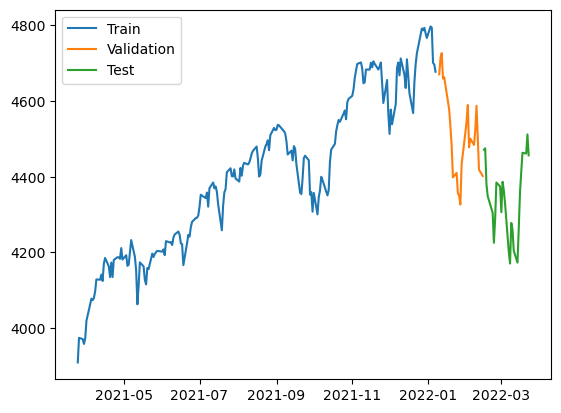

In [21]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 3s 85ms/step - loss: 19408822.0000 - mean_absolute_error: 4400.6802 - val_loss: 20384512.0000 - val_mean_absolute_error: 4513.5386
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 19406510.0000 - mean_absolute_error: 4400.4165 - val_loss: 20382512.0000 - val_mean_absolute_error: 4513.3174
Epoch 3/100
7/7 [==============================] - 0s 9ms/step - loss: 19404564.0000 - mean_absolute_error: 4400.1958 - val_loss: 20380542.0000 - val_mean_absolute_error: 4513.0991
Epoch 4/100
7/7 [==============================] - 0s 9ms/step - loss: 19402666.0000 - mean_absolute_error: 4399.9805 - val_loss: 20378488.0000 - val_mean_absolute_error: 4512.8716
Epoch 5/100
7/7 [==============================] - 0s 9ms/step - loss: 19399686.0000 - mean_absolute_error: 4399.6406 - val_loss: 20374124.0000 - val_mean_absolute_error: 4512.3882
Epoch 6/100
7/7 [==============================] - 0s 10ms/step - loss: 19395750.0000 - mean_

Epoch 46/100
7/7 [==============================] - 0s 11ms/step - loss: 16338879.0000 - mean_absolute_error: 4036.8088 - val_loss: 17104410.0000 - val_mean_absolute_error: 4134.2393
Epoch 47/100
7/7 [==============================] - 0s 13ms/step - loss: 16134341.0000 - mean_absolute_error: 4011.3933 - val_loss: 16889446.0000 - val_mean_absolute_error: 4108.1587
Epoch 48/100
7/7 [==============================] - 0s 10ms/step - loss: 15922203.0000 - mean_absolute_error: 3984.9170 - val_loss: 16667188.0000 - val_mean_absolute_error: 4081.0186
Epoch 49/100
7/7 [==============================] - 0s 10ms/step - loss: 15703667.0000 - mean_absolute_error: 3957.3250 - val_loss: 16436979.0000 - val_mean_absolute_error: 4052.7156
Epoch 50/100
7/7 [==============================] - 0s 10ms/step - loss: 15477150.0000 - mean_absolute_error: 3928.6243 - val_loss: 16199721.0000 - val_mean_absolute_error: 4023.3374
Epoch 51/100
7/7 [==============================] - 0s 10ms/step - loss: 15243823.000

7/7 [==============================] - 0s 13ms/step - loss: 3675739.7500 - mean_absolute_error: 1905.8259 - val_loss: 3937838.7500 - val_mean_absolute_error: 1981.2524
Epoch 92/100
7/7 [==============================] - 0s 11ms/step - loss: 3448649.5000 - mean_absolute_error: 1845.3187 - val_loss: 3702786.0000 - val_mean_absolute_error: 1921.0175
Epoch 93/100
7/7 [==============================] - 0s 9ms/step - loss: 3230512.7500 - mean_absolute_error: 1785.2195 - val_loss: 3476357.5000 - val_mean_absolute_error: 1861.1500
Epoch 94/100
7/7 [==============================] - 0s 10ms/step - loss: 3020448.7500 - mean_absolute_error: 1725.5421 - val_loss: 3258678.7500 - val_mean_absolute_error: 1801.7217
Epoch 95/100
7/7 [==============================] - 0s 12ms/step - loss: 2819011.2500 - mean_absolute_error: 1666.2362 - val_loss: 3049263.7500 - val_mean_absolute_error: 1742.6377
Epoch 96/100
7/7 [==============================] - 0s 12ms/step - loss: 2626488.7500 - mean_absolute_error: 

7/7 [==============================] - 0s 5ms/step


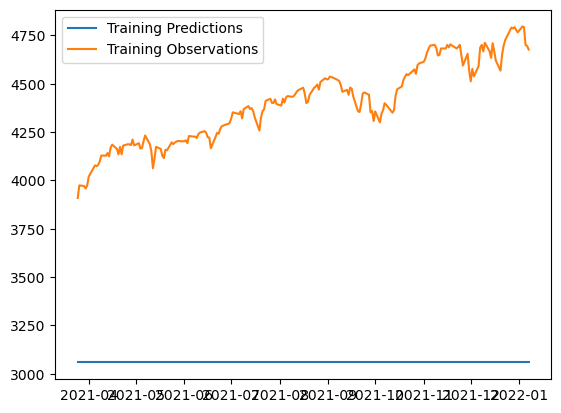

In [50]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])